In [2]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.stats as ss

import folium
from folium import plugins

from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [3]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=object)

vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=object)

people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=object)

In [5]:
train_new = pd.read_csv('Preprocessed_data.csv')

In [6]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54388 entries, 0 to 54387
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CRASH_DATE               54388 non-null  object 
 1   POSTED_SPEED_LIMIT       54388 non-null  int64  
 2   TRAFFIC_CONTROL_DEVICE   54388 non-null  object 
 3   DEVICE_CONDITION         54388 non-null  object 
 4   WEATHER_CONDITION        54388 non-null  object 
 5   LIGHTING_CONDITION       54388 non-null  object 
 6   FIRST_CRASH_TYPE         54388 non-null  object 
 7   TRAFFICWAY_TYPE          54388 non-null  object 
 8   LANE_CNT                 54388 non-null  int64  
 9   ALIGNMENT                54388 non-null  object 
 10  ROADWAY_SURFACE_COND     54388 non-null  object 
 11  ROAD_DEFECT              54388 non-null  object 
 12  INTERSECTION_RELATED_I   54388 non-null  object 
 13  NOT_RIGHT_OF_WAY_I       54388 non-null  object 
 14  HIT_AND_RUN_I         

In [7]:
train_new.groupby(['PERSON_TYPE']).size()

PERSON_TYPE
BICYCLE                  422
DRIVER                 45567
NON-CONTACT VEHICLE       13
NON-MOTOR VEHICLE         54
PEDESTRIAN               878
UNABLE TO DETERMINE     7454
dtype: int64

In [8]:
df=train_new
df.groupby(['CRASH_HOUR', 'INJURY']).size()


CRASH_HOUR     INJURY     
Afternoon      INJURED         2169
               NOT INJURED    20330
Early_morning  INJURED          765
               NOT INJURED     5921
Morning        INJURED          993
               NOT INJURED     9575
Night          INJURED         1965
               NOT INJURED    12670
dtype: int64

## Insight : More Injuries crashes vs. Crash hours
**Injured % of Crashes at Night, Early morning > Not-Injured %**

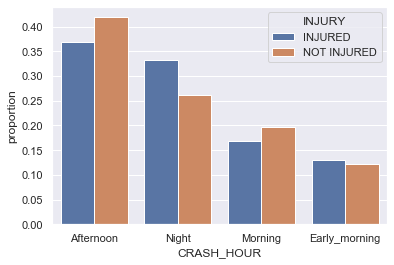

In [9]:
df=train_new
x, y, hue = "CRASH_HOUR", "proportion", "INJURY"
hue_order = ["Not Injured", "Injured"]
x_order = ['Night','Afternoon','Morning','Early_morning']

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

## Insight : Prim_contributory_cause in Different Hours
**All different hours, the PRIM_CONTRIBUTORY_CAUSE are all "FAILING TO YIELD RIGHT-OF-WAY"**

- Night : **No right of the way**, Fail to reduce speed, improper driving behavior
- Morning : **No right of the way**, Follow too closely, improper driving behavior
- Early morning : **No right of the way**, Follow too closely, Fail to reduce speed, improper driving behavior
- Afternoon : **No right of the way**, Follow too closely, improper driving behavior, fail to reduce the speed

**Below is the breakdown of PRIM_CONTRIBUTORY_CAUSE**

In [10]:
pd.set_option('display.max_rows', 200)
train_new = train_new[~train_new['PRIM_CONTRIBUTORY_CAUSE'].isin(['UNABLE TO DETERMINE', 'NOT APPLICABLE'])]
df=train_new
df.groupby(['CRASH_HOUR', 'PRIM_CONTRIBUTORY_CAUSE']).size().reset_index(name='count').sort_values(['CRASH_HOUR','count','PRIM_CONTRIBUTORY_CAUSE'], ascending=False)

,CRASH_HOUR,PRIM_CONTRIBUTORY_CAUSE,count
121,Night,FAILING TO YIELD RIGHT-OF-WAY,1429
122,Night,FOLLOWING TOO CLOSELY,1384
120,Night,FAILING TO REDUCE SPEED TO AVOID CRASH,838
126,Night,IMPROPER OVERTAKING/PASSING,635
124,Night,IMPROPER BACKING,581
125,Night,IMPROPER LANE USAGE,555
127,Night,IMPROPER TURNING/NO SIGNAL,510
109,Night,DISREGARDING TRAFFIC SIGNALS,436
115,Night,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,354
129,Night,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",312


## Insight : Posted_speed_limit
**Posted_speed_limit is higher in Night > Afternoon > Early_morning > Morning**

In [11]:
df=train_new
df.groupby(['CRASH_HOUR', 'POSTED_SPEED_LIMIT']).size().reset_index(name='count').sort_values(['POSTED_SPEED_LIMIT','CRASH_HOUR', 'count'], ascending=False)

,CRASH_HOUR,POSTED_SPEED_LIMIT,count
57,Night,70,1
13,Afternoon,60,2
56,Night,55,10
42,Morning,55,7
26,Early_morning,55,10
12,Afternoon,55,5
55,Night,50,2
41,Morning,50,2
25,Early_morning,50,2
54,Night,45,64


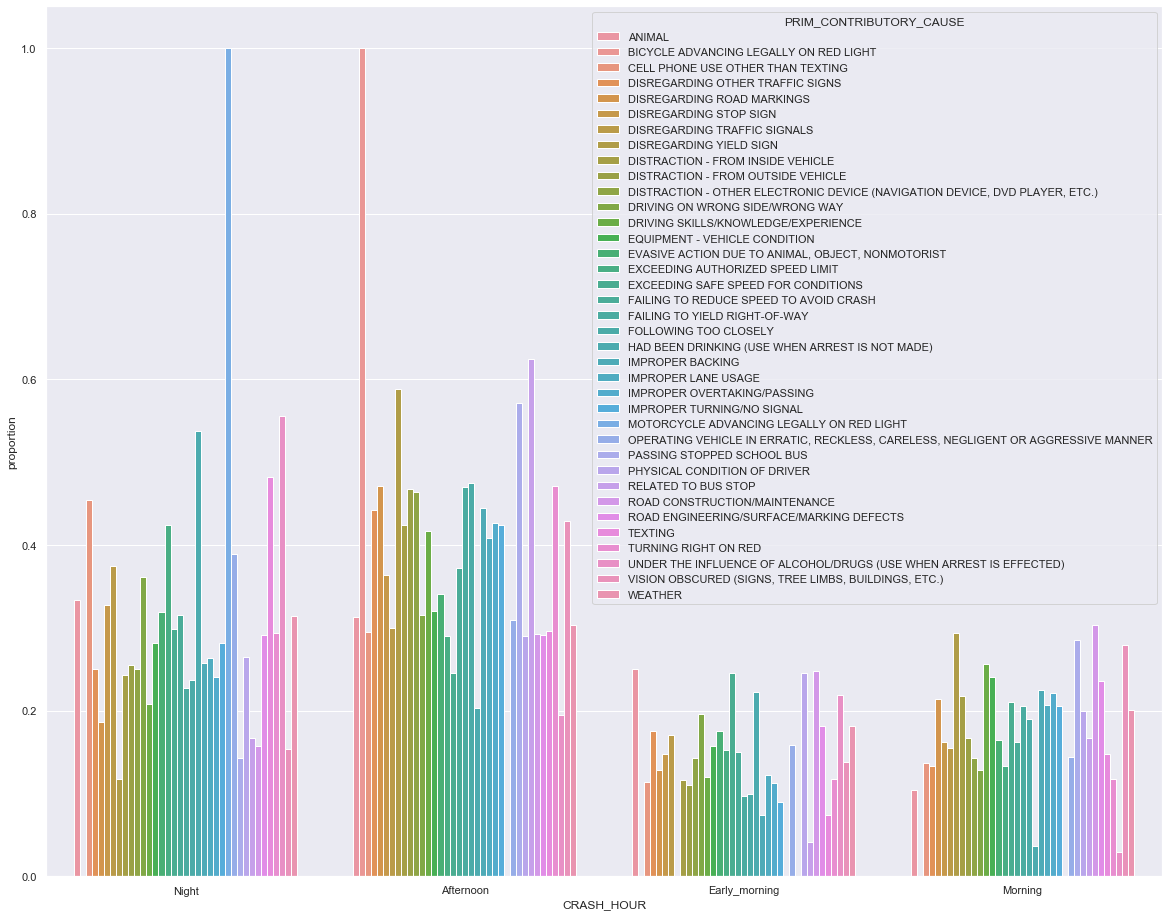

In [12]:
x, y, hue = "CRASH_HOUR", "proportion", "PRIM_CONTRIBUTORY_CAUSE"
plt.figure(figsize = (20,16))
# hue_order = ["Not Injured", "Injured"]
# x_order = ['Night','Afternoon','Morning','Early_morning']

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [13]:
df=train_new
x,y = 'CRASH_HOUR', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
df1 = df1[df1["CRASH_HOUR"]=="Early_morning"]


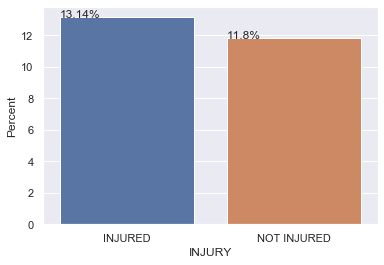

In [14]:
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

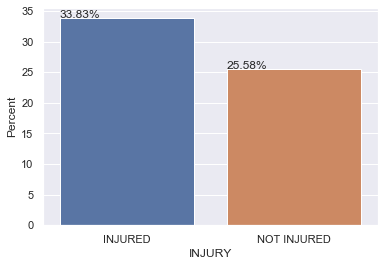

In [15]:
df=train_new
x,y = 'CRASH_HOUR', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
df1 = df1[df1["CRASH_HOUR"]=="Night"]
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

In [16]:
df=train_new
x,y = 'CRASH_HOUR', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
df1 = df1[df1["CRASH_HOUR"]=="Early_morning"]

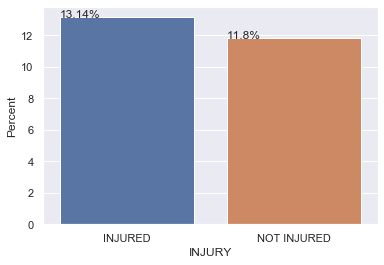

In [17]:
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

In [18]:
train_new = train_new[~train_new['PRIM_CONTRIBUTORY_CAUSE'].isin(['UNABLE TO DETERMINE', 'NOT APPLICABLE'])]
train_new[train_new["FIRST_CRASH_TYPE"] == "PEDESTRIAN"].groupby(['PRIM_CONTRIBUTORY_CAUSE'])\
                                                                    .size() \
                                                                    .reset_index(name='count') \
                                                                    .sort_values(['count'], ascending=False)


,PRIM_CONTRIBUTORY_CAUSE,count
15,FAILING TO YIELD RIGHT-OF-WAY,428
14,FAILING TO REDUCE SPEED TO AVOID CRASH,59
5,DISREGARDING TRAFFIC SIGNALS,56
27,"VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS,...",46
18,IMPROPER BACKING,41
22,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",38
23,PHYSICAL CONDITION OF DRIVER,23
10,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,21
28,WEATHER,20
4,DISREGARDING STOP SIGN,16


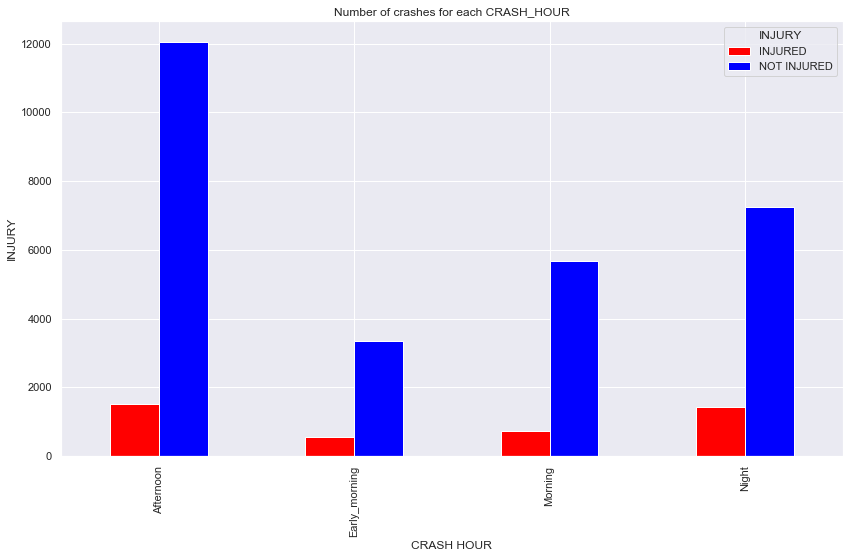

In [19]:
ax = df.groupby(['INJURY','CRASH_HOUR'])['CRASH_HOUR'].count().unstack(0).plot.bar(title="Number of crashes for each CRASH_HOUR", 
                                                                                                  figsize=(14,8), color=['red', 'blue'])
_ = ax.set_xlabel('CRASH HOUR')
_ = ax.set_ylabel('INJURY')

## Insight : Aged group
**Different Age group has different attributing contributor**

In [20]:
# df.groupby(['AGE']).size() # age 0~103

In [24]:
def age_group(x):
    if  0.0 <= x <= 18.0:
        return "Under 18"
    elif 18.0 < x <= 30.0:
        return "between 19 and 30"
    elif 30.0< x <= 40.0:
        return "between 31 and 40"
    elif 40.0< x <= 50.0:
        return "between 41 and 50"
    elif 50.0< x <= 60.0:
        return "between 51 and 60"
    else:
        return "Over 60"
    
# replacing NA values with OTHER
df["AGE_binned"] = df["AGE"].apply(lambda x: age_group(int(x)))
df.groupby(['AGE_binned']).size()

AGE_binned
Over 60              2913
Under 18              975
between 19 and 30    8199
between 31 and 40    9022
between 41 and 50    7285
between 51 and 60    4118
dtype: int64

**Age Group of below have more injured% > not-injured%**
- Between 19~30
- Over 60 
- Under 18

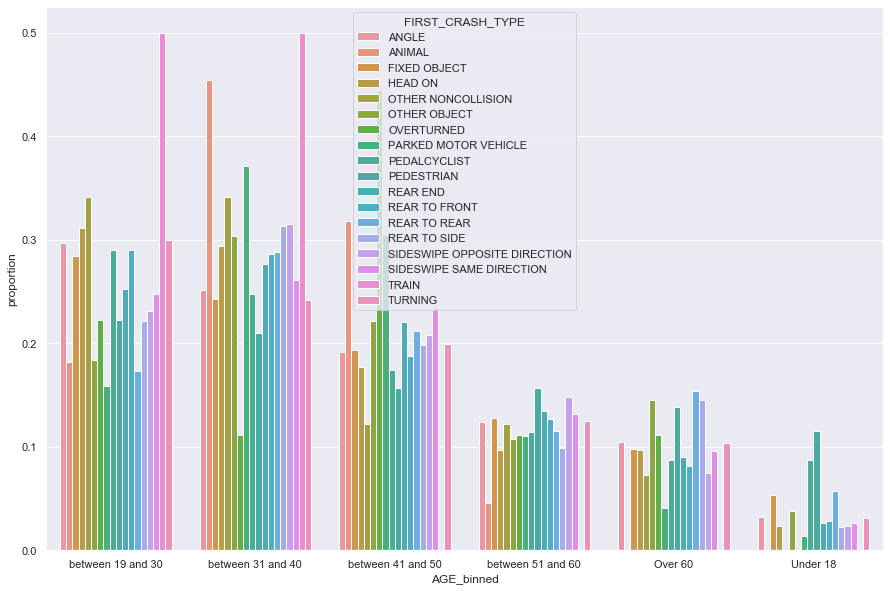

In [25]:
df=train_new
x, y, hue = "AGE_binned", "proportion", "FIRST_CRASH_TYPE"
plt.figure(figsize = (15,10))

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [26]:
pd.set_option('display.max_rows', None) 

In [27]:
train_new[train_new["AGE_binned"] == "Under 18"].groupby(['PRIM_CONTRIBUTORY_CAUSE', "CRASH_HOUR", "LIGHTING_CONDITION"])\
                                                                    .size() \
                                                                    .reset_index(name='count') \
                                                                    .sort_values(['CRASH_HOUR', 'count'], ascending=False)

,PRIM_CONTRIBUTORY_CAUSE,CRASH_HOUR,LIGHTING_CONDITION,count
90,FAILING TO YIELD RIGHT-OF-WAY,Night,"DARKNESS, LIGHTED ROAD",39
77,FAILING TO REDUCE SPEED TO AVOID CRASH,Night,"DARKNESS, LIGHTED ROAD",17
104,FOLLOWING TOO CLOSELY,Night,"DARKNESS, LIGHTED ROAD",17
19,DISREGARDING TRAFFIC SIGNALS,Night,"DARKNESS, LIGHTED ROAD",14
46,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,Night,"DARKNESS, LIGHTED ROAD",14
132,IMPROPER OVERTAKING/PASSING,Night,"DARKNESS, LIGHTED ROAD",11
123,IMPROPER LANE USAGE,Night,"DARKNESS, LIGHTED ROAD",10
92,FAILING TO YIELD RIGHT-OF-WAY,Night,DAYLIGHT,9
143,IMPROPER TURNING/NO SIGNAL,Night,"DARKNESS, LIGHTED ROAD",9
89,FAILING TO YIELD RIGHT-OF-WAY,Night,DARKNESS,8


In [ ]:
df=train_new
x, y, hue = "AGE_binned", "proportion", "INJURY"
hue_order = ["Not Injured", "Injured"]
plt.figure(figsize = (15,8))

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [ ]:
df=train_new
display(df.groupby(['TRAFFIC_CONTROL_DEVICE']).size())
x, y, hue = "TRAFFIC_CONTROL_DEVICE", "proportion", "INJURY"
hue_order = ["Not Injured", "Injured"]

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [ ]:
df=train_new
x, y, hue = "AGE_binned", "proportion", "PRIM_CONTRIBUTORY_CAUSE"
plt.figure(figsize = (20,15))

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [ ]:
# BICYCLE & PEDESTRIAN No# INJURED > NOT INJURED
train_new.groupby(['PERSON_TYPE', 'INJURY']).size().reset_index()


In [ ]:
df=train_new
x, y, hue = "AGE_binned", "proportion", "INJURY"
hue_order = ["Not Injured", "Injured"]
plt.figure(figsize = (15,8))

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [ ]:
# bins = [-np.inf, 12.0, 18.0, 22.0, 65.0, np.inf]
# labels = ['Under 12', '13~18', '19~22', '23~65', 'Above 65']

# df['AGE_binned'] = pd.cut(df['AGE'], bins=bins, labels=labels)
# print(df)

## Insight : Safety equipment
**Used safety equipment has less injured%**

In [ ]:
train_new1 = train_new[~train_new['SAFETY_EQUIPMENT'].isin(['CHILD RESTRAINT - TYPE UNKNOWN', 'UNABLE TO DETERMINE'])]
df1=train_new1
display(df1.groupby(['SAFETY_EQUIPMENT']).size())
x, y, hue = "SAFETY_EQUIPMENT", "proportion", "INJURY"
hue_order = ["Not Injured", "Injured"]
plt.figure(figsize = (15,8))

(df1[x]
 .groupby(df1[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

In [ ]:
train_new = train_new[~train_new['PRIM_CONTRIBUTORY_CAUSE'].isin(['UNABLE TO DETERMINE', 'NOT APPLICABLE'])]
train_new[train_new["FIRST_CRASH_TYPE"] == "PEDALCYCLIST"].groupby(['PRIM_CONTRIBUTORY_CAUSE'])\
                                                                    .size() \
                                                                    .reset_index(name='count') \
                                                                    .sort_values(['count'], ascending=False)



In [ ]:
ax = train_new.groupby(['INJURY','FIRST_CRASH_TYPE'])['PERSON_TYPE'].count().unstack(0).plot.bar(title="Number of crashes for each FIRST_CRASH_TYPE", 
                                                                                                  figsize=(14,8), color=['red', 'blue'])
_ = ax.set_xlabel('FIRST_CRASH_TYPE')
_ = ax.set_ylabel('INJURY')

In [ ]:
df=train_new
x,y = 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["PRIM_CONTRIBUTORY_CAUSE"]=="DISREGARDING TRAFFIC SIGNALS"]

In [ ]:
ax = sns.barplot(x="INJURY", y="Percent", data=df1)
for p in ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)

In [ ]:
train_new.groupby(['PRIM_CONTRIBUTORY_CAUSE', 'INJURY']).size().reset_index()


In [ ]:
chicago_map = folium.Map(location=[41.864073,-87.706819], zoom_start=10.5)

In [ ]:
# convert to (n, 2) nd-array format for heatmap
stationArr = df[['LATITUDE', 'LONGITUDE']].values
# plot heatmap
chicago_map.add_child(plugins.HeatMap(stationArr, radius=11))
chicago_map

In [ ]:
def location(x1,x2):
    if (41.875297 <= float(x1) <= 41.9000064) and (-87.6321459 <= float(x2) <= -87.6096752):
        return "Downtown"
    else:
        return "Not Downtown"

#df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
df["Location_category"] = df.apply(lambda x: location(x["LATITUDE"],x["LONGITUDE"]), axis=1)

In [ ]:
display(df["Location_category"].unique())
df.groupby(['Location_category']).size()

In [ ]:
# convert to (n, 2) nd-array format for heatmap
stationArr = df[['LATITUDE', 'LONGITUDE']].values
# plot heatmap
chicago_map.add_child(plugins.HeatMap(stationArr, radius=11))
chicago_map

In [ ]:
plt.figure(figsize = (10,8))
df =train_new[(train_new.INJURY == 'NOT INJURED') & (train_new.VEHICLE_AGE.isin(range(0,2)))]
sns.distplot(df['AGE'], bins=30, kde=False,label='NOT INJURED')

df =train_new[(train_new.INJURY == 'INJURED') & (train_new.VEHICLE_AGE.isin(range(0,2)))]
sns.distplot(df['AGE'], bins=30, kde=False,label='INJURED')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Age of drivers involved in crash of new cars',fontsize=20)
plt.xlim([10, 80])
plt.xlabel('AGE')
plt.ylabel('Density')

In [ ]:
df=train_new
x,y = 'CRASH_HOUR', 'PRIM_CONTRIBUTORY_CAUSE'

df1 = df.groupby(y)[x].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('Percent').reset_index()
df1 = df1[df1["CRASH_HOUR"]=="Early_morning"]
